<a href="https://colab.research.google.com/github/helya02/cycleGAN/blob/main/cycleGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! pip install -q kaggle
! mkdir ~/.kaggle
#Upload the token json file
from google.colab import files
files.upload()
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets list

Saving kaggle.json to kaggle.json
ref                                                      title                                        size  lastUpdated          downloadCount  voteCount  usabilityRating  
-------------------------------------------------------  ------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
nelgiriyewithana/top-spotify-songs-2023                  Most Streamed Spotify Songs 2023             47KB  2023-08-26 11:04:57           4240        131  1.0              
nelgiriyewithana/global-youtube-statistics-2023          Global YouTube Statistics 2023               60KB  2023-07-28 15:36:38          15413        520  1.0              
alitaqi000/global-population-trends2016-2022             Global Population Trends(2016-2022)          32KB  2023-08-28 12:53:06            951         22  1.0              
utkarshtomar736/ipl-mens-cricket-matches-data-2008-2023  IPL Men's Cricket Matches Data (2008-2023)  

In [ ]:
! kaggle datasets download -d ashwingupta3012/male-and-female-faces-dataset

100% 1.63G/1.63G [00:20<00:00, 69.0MB/s]
100% 1.63G/1.63G [00:20<00:00, 85.1MB/s]


In [ ]:
!unzip "male-and-female-faces-dataset.zip"

Streaming output truncated to the last 5000 lines.
  inflating: Male and Female face dataset/Female Faces/0 (1367).jpg  
  inflating: Male and Female face dataset/Female Faces/0 (1368).jpg  
  inflating: Male and Female face dataset/Female Faces/0 (1369).jpg  
  inflating: Male and Female face dataset/Female Faces/0 (137).jpg  
  inflating: Male and Female face dataset/Female Faces/0 (1370).jpg  
  inflating: Male and Female face dataset/Female Faces/0 (1371).jpg  
  inflating: Male and Female face dataset/Female Faces/0 (1372).jpg  
  inflating: Male and Female face dataset/Female Faces/0 (1373).jpg  
  inflating: Male and Female face dataset/Female Faces/0 (1374).jpg  
  inflating: Male and Female face dataset/Female Faces/0 (1375).jpg  
  inflating: Male and Female face dataset/Female Faces/0 (1376).jpg  
  inflating: Male and Female face dataset/Female Faces/0 (1377).jpg  
  inflating: Male and Female face dataset/Female Faces/0 (1378).jpg  
  inflating: Male and Female face datase

In [ ]:
from __future__ import print_function
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt


In [ ]:
workers = 4
batch_size = 1
image_size = 64
nc = 3
nz = 3
ngf = 64
ndf = 64
num_epochs = 50



In [ ]:
import os
import shutil

def categorize_images(main_folder, folder_0, folder_1):
    # Create destination folders if they don't exist
    if not os.path.exists(folder_0):
        os.makedirs(folder_0)
    if not os.path.exists(folder_1):
        os.makedirs(folder_1)

    # Iterate through the main folder
    for root, dirs, files in os.walk(main_folder):
        for file in files:
            if file.startswith('0'):
                # Move the image to folder_0 (female)
                shutil.copy(os.path.join(root, file), os.path.join(folder_0, file))
            elif file.startswith('1'):
                # Move the image to folder_1 (male)
                shutil.copy(os.path.join(root, file), os.path.join(folder_1, file))

# Customize the paths here
main_folder = '/content/Male and Female face dataset/Male Faces'#@param ['/content/Male and Female face dataset/Male Faces','/content/Male and Female face dataset/Female Faces']
#main_folder = '/content/Male and Female face dataset/Female Faces'

folder_0 = '/content/female/class'
folder_1 = '/content/male/class'

# Call the function
categorize_images(main_folder, folder_0, folder_1)

In [ ]:
dataset_female = dset.ImageFolder(root="/content/female",
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))

dataset_male = dset.ImageFolder(root="/content/male",
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))



# Create the dataloader





dataloader_female = torch.utils.data.DataLoader(dataset_female , batch_size=batch_size,
                                         shuffle=True, num_workers=workers)
dataloader_male = torch.utils.data.DataLoader(dataset_male , batch_size=batch_size,
                                         shuffle=True, num_workers=workers)

# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available()) else "cpu")

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


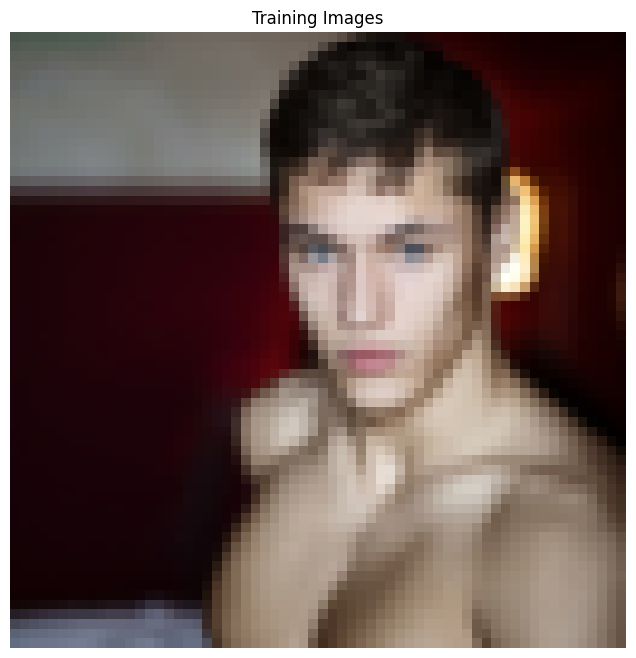

In [ ]:
real_batch = next(iter(dataloader_male))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision.transforms import transforms
from torch.autograd import Variable
import torch.nn.functional as F
import itertools
import torchvision
from torchvision.utils import save_image
from torchvision.transforms import ToPILImage
import random
import torch.optim.lr_scheduler as lr_scheduler


class ConvNet(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x = self.double_conv(x)
        # print("Double Conv ==== >", x.size())
        return x


class DownConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            ConvNet(in_channels, out_channels)
        )

    def forward(self, x):
        x = self.maxpool_conv(x)
        # print("Down ==== >", x.size())
        return x


class UpConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.up = nn.ConvTranspose2d(in_channels , in_channels // 2, kernel_size=2, stride=2)
        self.conv = ConvNet(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        x2 = torchvision.transforms.CenterCrop([x1.size(2), x1.size(3)])(x2)
        x = torch.cat([x2, x1], dim=1)
        # print("Up ==== >", x.size())
        x = self.conv(x)
        # print("Up ==== >", x.size())
        return x

class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        self.inc = ConvNet(3, 64)
        self.down1 = DownConv(64, 128)
        self.down2 = DownConv(128, 256)
        self.down3 = DownConv(256, 512)
        self.down4 = DownConv(512, 1024)

        self.up1 = UpConv(1024, 512)
        self.up2 = UpConv(512, 256)
        self.up3 = UpConv(256, 128)
        self.up4 = UpConv(128, 64)
        self.outc = nn.Conv2d(64, 3, 1)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        # print("Finished Encoder ------------")
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits


class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.layer = UNet()

    def forward(self, x):

        return self.layer(x)


class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(3, 64, 4, 2, 1, bias=False),
            nn.ReLU(inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(64, 128, 4, 2, 1, bias=False),
            nn.InstanceNorm2d(128),
            nn.ReLU(inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(128, 256, 4, 2, 1, bias=False),
            nn.InstanceNorm2d(256),
            nn.ReLU(inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(256, 512, 4, 2, 1, bias=False),
            nn.InstanceNorm2d(512),
            nn.ReLU(inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(512, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )
    def forward(self, input):
        return self.main(input)

# Define the CycleGAN model
class CycleGAN(nn.Module):
    def __init__(self, G_AB, G_BA, D_A, D_B):
        super(CycleGAN, self).__init__()
        self.G_AB = G_AB
        self.G_BA = G_BA
        self.D_A = D_A
        self.D_B = D_B

    '''def forward(self, real_A, real_B):
        fake_A = G_AB(real_A)
        fake_B = G_AB(real_A)


        return fake_A, fake_B, rec_A, rec_B'''

# Set device (GPU or CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Set output directories
output_dir_A = "/content/output_images/domainA"
output_dir_B = "/content/output_images/domainB"

# Initialize the generators and discriminators
G_AB = Generator().to(device)
G_BA = Generator().to(device)
D_A = Discriminator().to(device)
D_B = Discriminator().to(device)

# Initialize the CycleGAN model
cycleGAN = CycleGAN(G_AB, G_BA, D_A, D_B).to(device)

# Define the loss functions
criterion_GAN = nn.MSELoss()
criterion_cycle = nn.L1Loss()

# Define the optimizers for generators and discriminators
optimizer_G = optim.Adam(itertools.chain(G_AB.parameters(), G_BA.parameters()), lr=0.0002, betas=(0.5,0.999))
optimizer_D = optim.Adam(itertools.chain(D_A.parameters(), D_B.parameters()), lr=0.0002, betas=(0.5,0.999))

#scheduler1 = lr_scheduler.StepLR(optimizer_G, step_size=10, gamma=0.1)
#scheduler2 = lr_scheduler.StepLR(optimizer_D, step_size=10, gamma=0.1)



iter1 = itertools.cycle(iter(dataloader_female))
iter2 = itertools.cycle(iter(dataloader_male))

for epoch in range(num_epochs):
    print("epoch {}/{} ---->".format(epoch,num_epochs))
    for _ in range(len(dataloader_female)) :
        i = _
        # Move real images to device
        real_A, _ = next(iter1)
        real_B, _ = next(iter2)
        real_A = real_A.to(device)
        real_B = real_B.to(device)
        # Train the generators
        optimizer_G.zero_grad()
        # Forward pass through generators
        fake_B = G_AB(real_A)
        rec_A = G_BA(fake_B)
        fake_A = G_BA(real_B)
        rec_B = G_AB(fake_A)
        # Compute generator adversarial loss
        loss_GAN_AB = criterion_GAN(D_B(fake_B), torch.ones_like(D_B(fake_B)))
        loss_GAN_BA = criterion_GAN(D_A(fake_A), torch.ones_like(D_A(fake_A)))
        # Compute cycle consistency loss
        loss_cycle_A = criterion_cycle(rec_A, real_A)
        loss_cycle_B = criterion_cycle(rec_B, real_B)
        # Total generator loss
        loss_G = loss_GAN_AB + loss_GAN_BA + 10 * (loss_cycle_A + loss_cycle_B)
        # Backward pass and optimize
        loss_G.backward()
        optimizer_G.step()
        # Train the discriminators
        optimizer_D.zero_grad()
        # Compute discriminator A loss
        loss_D_A_real = criterion_GAN(D_A(real_A), torch.ones_like(D_A(real_A)))
        loss_D_A_fake = criterion_GAN(D_A(fake_A.detach()), torch.zeros_like(D_A(fake_A.detach())))
        loss_D_A = (loss_D_A_real + loss_D_A_fake) * 0.5
        # Compute discriminator B loss
        loss_D_B_real = criterion_GAN(D_B(real_B), torch.ones_like(D_B(real_B)))
        loss_D_B_fake = criterion_GAN(D_B(fake_B.detach()), torch.zeros_like(D_B(fake_B.detach())))
        loss_D_B = (loss_D_B_real + loss_D_B_fake) * 0.5
        # Total discriminator loss
        loss_D = loss_D_A + loss_D_B
        # Backward pass and optimize
        loss_D.backward()
        optimizer_D.step()
        # Print losses
        if i % 100 == 0:
            print(f"Loss_D: {loss_D.item():.4f}, Loss_G: {loss_G.item():.4f}")

        # Save the translated images

    #scheduler1.step()
    #scheduler2.step()
    if epoch == 0 :
      save_image(real_A, f"{output_dir_B}/real_A_fake_B_{epoch}.png")
      save_image(real_B, f"{output_dir_A}/real_B_fake_A_{epoch}.png")

    save_image(fake_B, f"{output_dir_B}/fake_B_{epoch}.png")
    save_image(fake_A, f"{output_dir_A}/fake_A_{epoch}.png")


    # Convert images to PIL format for visualization (optional)
    pil_converter = ToPILImage()
    fake_B_pil = pil_converter(fake_B[0].cpu())
    fake_A_pil = pil_converter(fake_A[0].cpu())

    # Display the translated images (optional)
    fake_B_pil.show()
    fake_A_pil.show()


epoch 0/50 ---->
Loss_D: 0.5288, Loss_G: 11.2168
Loss_D: 0.4932, Loss_G: 6.2621
Loss_D: 1.1785, Loss_G: 4.2449


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Loss_D: 0.5670, Loss_G: 7.8102
Loss_D: 0.9361, Loss_G: 4.0439
Loss_D: 0.6210, Loss_G: 5.2991


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Loss_D: 0.7955, Loss_G: 4.3763
Loss_D: 0.4943, Loss_G: 4.5831
Loss_D: 0.7139, Loss_G: 3.6182
Loss_D: 0.3736, Loss_G: 4.2644
Loss_D: 0.1419, Loss_G: 4.1294
Loss_D: 0.1739, Loss_G: 6.3783
Loss_D: 0.6454, Loss_G: 5.5420
Loss_D: 0.5705, Loss_G: 4.0156
Loss_D: 0.6733, Loss_G: 6.4444
Loss_D: 0.0581, Loss_G: 5.2449
Loss_D: 0.0463, Loss_G: 6.1646
Loss_D: 0.7748, Loss_G: 6.2238
Loss_D: 0.0306, Loss_G: 5.4200
Loss_D: 1.4859, Loss_G: 3.1961
Loss_D: 0.3825, Loss_G: 4.8820
Loss_D: 0.1711, Loss_G: 4.3360
Loss_D: 0.1891, Loss_G: 4.3587
Loss_D: 0.0703, Loss_G: 6.0402
Loss_D: 0.9383, Loss_G: 2.9149
Loss_D: 0.6190, Loss_G: 4.1329
Loss_D: 0.1891, Loss_G: 4.5856
epoch 1/50 ---->
Loss_D: 0.4320, Loss_G: 3.7089
Loss_D: 0.0664, Loss_G: 5.8742
Loss_D: 0.8050, Loss_G: 4.9264
Loss_D: 0.4413, Loss_G: 5.6384
Loss_D: 0.7601, Loss_G: 4.3904
Loss_D: 0.1185, Loss_G: 4.5827
Loss_D: 0.0171, Loss_G: 4.1923
Loss_D: 0.1886, Loss_G: 3.8663
Loss_D: 0.1883, Loss_G: 4.3372
Loss_D: 0.1052, Loss_G: 4.7349
Loss_D: 0.3039, Loss_G

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive
